In [19]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load Dataset

In [22]:
dataset = pd.read_parquet(r'../local_dataset/dataset/merged_full2.parquet')

# Keep lon/lat for visualization only
lon_lat = dataset[['lon', 'lat']].copy()

# Remove lon/lat and fire from clustering
dataset.drop(columns=['lon', 'lat', 'fire'], inplace=True, errors='ignore')
print("=== Dataset Types :\n", dataset.dtypes)

dataset_numeric_columns = dataset.select_dtypes(include=['number']).columns
dataset_string_columns = dataset.select_dtypes(include=['object']).columns
dataset[dataset_numeric_columns] = dataset[dataset_numeric_columns].fillna(dataset[dataset_numeric_columns].mean())
dataset[dataset_string_columns] = dataset[dataset_string_columns].fillna(dataset[dataset_string_columns].mode().iloc[0])

print("=== Null Values :\n", dataset.isnull().sum())

X = dataset.copy()
X_numeric_columns = X.select_dtypes(include=['number']).columns
X[X_numeric_columns] = StandardScaler().fit_transform(X[X_numeric_columns])
X = pd.get_dummies(X, columns=X.select_dtypes(include=['object']).columns)

print("=== X shape:", X.shape)
print("=== X columns:", X.columns)

=== Dataset Types :
 log_precip_s1             float64
log_precip_s2             float64
log_precip_s3             float64
log_precip_s4             float64
tmax_s1                   float64
tmax_s2                   float64
tmax_s3                   float64
tmax_s4                   float64
amplitude_thermique_s1    float64
amplitude_thermique_s2    float64
amplitude_thermique_s3    float64
amplitude_thermique_s4    float64
GRIDCODE                  float64
log_area_sqm              float64
lcc_code_encoded          float64
elevation                 float32
COARSE                    float64
SAND                      float64
SILT                      float64
CLAY                      float64
TEXTURE_USDA              float64
TEXTURE_SOTER              object
BULK                      float64
REF_BULK                  float64
ORG_CARBON                float64
PH_WATER                  float64
TOTAL_N                   float64
CN_RATIO                  float64
CEC_SOIL                  f

# SKlearn Model Training

In [17]:
kmeans = KMeans(n_clusters=21, random_state=42, n_init=10)

kmeans.fit(X)

labels_sklearn = kmeans.labels_
print(f"Sklearn K-Means - Number of clusters: {kmeans.n_clusters}")
print(f"Sklearn K-Means - Inertia: {kmeans.inertia_:.2f}")

Sklearn K-Means - Number of clusters: 21
Sklearn K-Means - Inertia: 487244.53


# Scratch Model Training

In [ ]:
import numpy as np

class FastKMeans:
    def __init__(self, n_clusters=21, max_iter=300, random_state=42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.centroids = None
        self.labels_ = None
        self.inertia_ = None
        
    def fit(self, X):
        np.random.seed(self.random_state)
        
        # Initialize centroids randomly
        random_indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        self.centroids = X[random_indices]
        
        for iteration in range(self.max_iter):
            # Assign points to nearest centroid
            distances = self._compute_distances(X)
            new_labels = np.argmin(distances, axis=1)
            
            # Check convergence
            if iteration > 0 and np.array_equal(new_labels, self.labels_):
                break
                
            self.labels_ = new_labels
            
            # Update centroids
            for k in range(self.n_clusters):
                cluster_points = X[self.labels_ == k]
                if len(cluster_points) > 0:
                    self.centroids[k] = cluster_points.mean(axis=0)
        
        # Calculate inertia (sum of squared distances to centroids)
        self.inertia_ = self._calculate_inertia(X)
        
        return self
    
    def _compute_distances(self, X):
        """
        Vectorized distance computation from all points to all centroids.
        Uses (a - b)^2 = a^2 + b^2 - 2ab trick.
        """
        X_square = np.sum(X**2, axis=1).reshape(-1, 1)
        centroids_square = np.sum(self.centroids**2, axis=1)
        cross = X @ self.centroids.T
        
        distances = X_square + centroids_square - 2 * cross
        return distances
    
    def _calculate_inertia(self, X):
        """Calculate sum of squared distances to nearest centroid"""
        distances = self._compute_distances(X)
        min_distances = np.min(distances, axis=1)
        return np.sum(min_distances)
    
    def predict(self, X):
        """Assign points to nearest centroid"""
        distances = self._compute_distances(X)
        return np.argmin(distances, axis=1)


kmeans_scratch = FastKMeans(n_clusters=3, random_state=42)
kmeans_scratch.fit(X.to_numpy())

print(f"Scratch K-Means - Number of clusters: {kmeans_scratch.n_clusters}")
print(f"Scratch K-Means - Inertia: {kmeans_scratch.inertia_:.2f}")

# SKlearn Model Evaluation

=== SKlearn K-Means Metrics ===
Silhouette Score: 0.2485
Davies-Bouldin Index: 1.4594
Calinski-Harabasz Index: 9550.0029

=== Cluster Distribution ===
Cluster 0: 2180 points (3.83%)
Cluster 1: 5316 points (9.35%)
Cluster 2: 2773 points (4.88%)
Cluster 3: 6653 points (11.70%)
Cluster 4: 3150 points (5.54%)
Cluster 5: 2120 points (3.73%)
Cluster 6: 3458 points (6.08%)
Cluster 7: 8453 points (14.87%)
Cluster 8: 579 points (1.02%)
Cluster 9: 4001 points (7.04%)
Cluster 10: 1428 points (2.51%)
Cluster 11: 498 points (0.88%)
Cluster 12: 3248 points (5.71%)
Cluster 13: 1594 points (2.80%)
Cluster 14: 1092 points (1.92%)
Cluster 15: 1195 points (2.10%)
Cluster 16: 615 points (1.08%)
Cluster 17: 2284 points (4.02%)
Cluster 18: 2507 points (4.41%)
Cluster 19: 788 points (1.39%)
Cluster 20: 2932 points (5.16%)


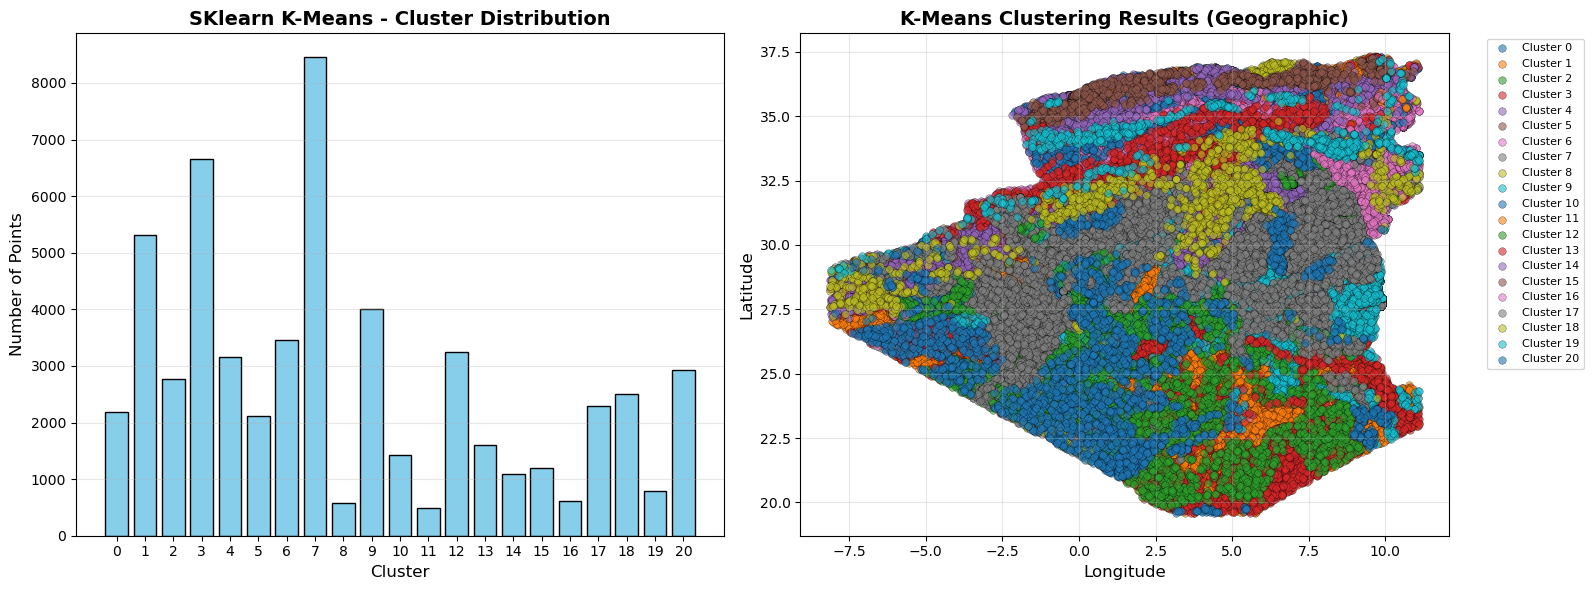

In [23]:
X_array = X.to_numpy()

silhouette = silhouette_score(X_array, labels_sklearn)
davies_bouldin = davies_bouldin_score(X_array, labels_sklearn)
calinski_harabasz = calinski_harabasz_score(X_array, labels_sklearn)

print("=== SKlearn K-Means Metrics ===")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")

# Distribution of clusters
unique, counts = np.unique(labels_sklearn, return_counts=True)
print("\n=== Cluster Distribution ===")
for cluster, count in zip(unique, counts):
    print(f"Cluster {cluster}: {count} points ({count/len(labels_sklearn)*100:.2f}%)")

# Visualize cluster distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
axes[0].bar(unique, counts, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Cluster', fontsize=12)
axes[0].set_ylabel('Number of Points', fontsize=12)
axes[0].set_title('SKlearn K-Means - Cluster Distribution', fontsize=14, fontweight='bold')
axes[0].set_xticks(unique)
axes[0].grid(axis='y', alpha=0.3)

# Geographic visualization (lon/lat)
for cluster in unique:
    mask = labels_sklearn == cluster
    axes[1].scatter(lon_lat.loc[mask, 'lon'], lon_lat.loc[mask, 'lat'], 
                   label=f'Cluster {cluster}', 
                   s=30, alpha=0.6, edgecolors='k', linewidth=0.3)

axes[1].set_xlabel('Longitude', fontsize=12)
axes[1].set_ylabel('Latitude', fontsize=12)
axes[1].set_title('K-Means Clustering Results (Geographic)', fontsize=14, fontweight='bold')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Scratch Model Evaluation

In [ ]:
labels_scratch = kmeans_scratch.labels_

silhouette_scratch = silhouette_score(X_array, labels_scratch)
davies_bouldin_scratch = davies_bouldin_score(X_array, labels_scratch)
calinski_harabasz_scratch = calinski_harabasz_score(X_array, labels_scratch)

print("=== Scratch K-Means Metrics ===")
print(f"Silhouette Score: {silhouette_scratch:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_scratch:.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_scratch:.4f}")

# Distribution of clusters
unique_scratch, counts_scratch = np.unique(labels_scratch, return_counts=True)
print("\n=== Cluster Distribution ===")
for cluster, count in zip(unique_scratch, counts_scratch):
    print(f"Cluster {cluster}: {count} points ({count/len(labels_scratch)*100:.2f}%)")

# Visualize cluster distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
axes[0].bar(unique_scratch, counts_scratch, color='coral', edgecolor='black')
axes[0].set_xlabel('Cluster', fontsize=12)
axes[0].set_ylabel('Number of Points', fontsize=12)
axes[0].set_title('Scratch K-Means - Cluster Distribution', fontsize=14, fontweight='bold')
axes[0].set_xticks(unique_scratch)
axes[0].grid(axis='y', alpha=0.3)

# Geographic visualization (lon/lat)
for cluster in unique_scratch:
    mask = labels_scratch == cluster
    axes[1].scatter(lon_lat.loc[mask, 'lon'], lon_lat.loc[mask, 'lat'], 
                   label=f'Cluster {cluster}', 
                   s=30, alpha=0.6, edgecolors='k', linewidth=0.3)

axes[1].set_xlabel('Longitude', fontsize=12)
axes[1].set_ylabel('Latitude', fontsize=12)
axes[1].set_title('K-Means Clustering Results (Geographic)', fontsize=14, fontweight='bold')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Comparison

In [ ]:
comparison_df = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index', 'Inertia'],
    'SKlearn': [silhouette, davies_bouldin, calinski_harabasz, kmeans.inertia_],
    'Scratch': [silhouette_scratch, davies_bouldin_scratch, calinski_harabasz_scratch, kmeans_scratch.inertia_]
})

print("=== Comparison of SKlearn vs Scratch K-Means ===")
print(comparison_df)

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index', 'Inertia']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    row = comparison_df[comparison_df['Metric'] == metric]
    
    ax.bar(['SKlearn', 'Scratch'], [row['SKlearn'].values[0], row['Scratch'].values[0]], 
           color=['skyblue', 'coral'], edgecolor='black')
    ax.set_title(metric)
    ax.set_ylabel('Value')
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()